**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
from skimage.feature import hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [2]:
import glob

vehicles_images = glob.glob("./vehicles/*/*.png")
print("Number of Vehicles Images: ", len(vehicles_images))
non_vehicles_images = glob.glob("./non-vehicles/*/*.png")
print("Number of Non-Vehicles Images: ", len(non_vehicles_images))


Number of Vehicles Images:  8792
Number of Non-Vehicles Images:  8968


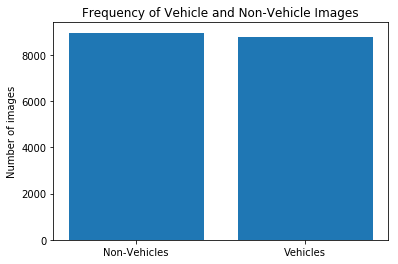

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

x_values = ["Vehicles", "Non-Vehicles"]
y_values = [len(vehicles_images), len(non_vehicles_images)]
plt.bar(x_values, y_values)
plt.ylabel("Number of images")
plt.title("Frequency of Vehicle and Non-Vehicle Images")
plt.show()

Image Size:  (64, 64, 3)


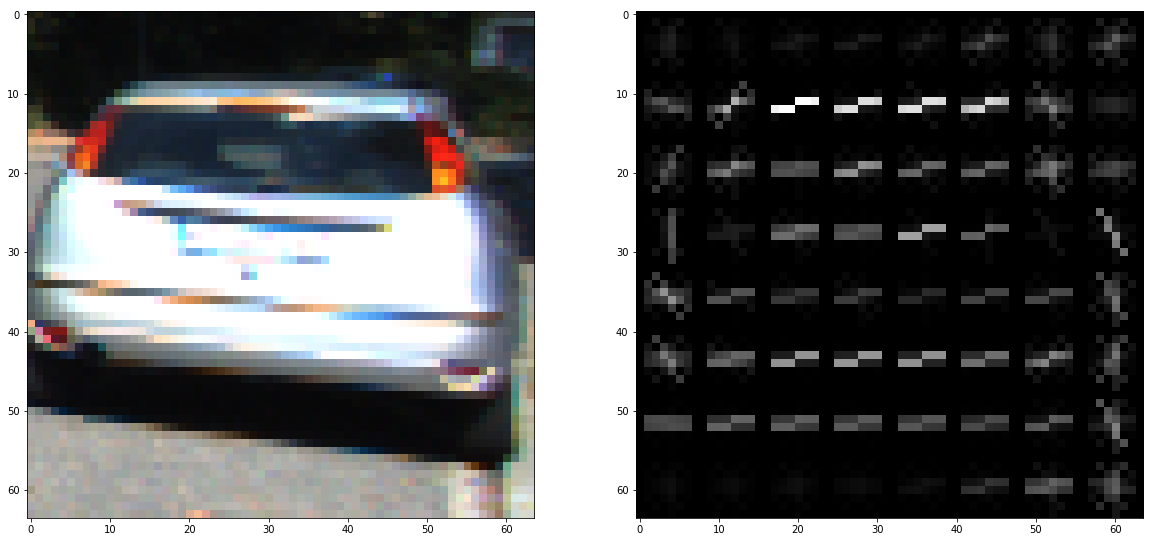

In [4]:
import matplotlib.image as mpimg
import numpy as np
import cv2

# Random car image
carImage = mpimg.imread(vehicles_images[np.random.randint(0, len(vehicles_images))])
print("Image Size: ", carImage.shape )
features, hog_image = get_hog_features(cv2.cvtColor(carImage, cv2.COLOR_RGB2GRAY), orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)

f, (a1, a2) = plt.subplots(1,2,figsize=(20,10))
a1.imshow(carImage)
a2.imshow(hog_image, cmap='gray')

Image Size:  (64, 64, 3)


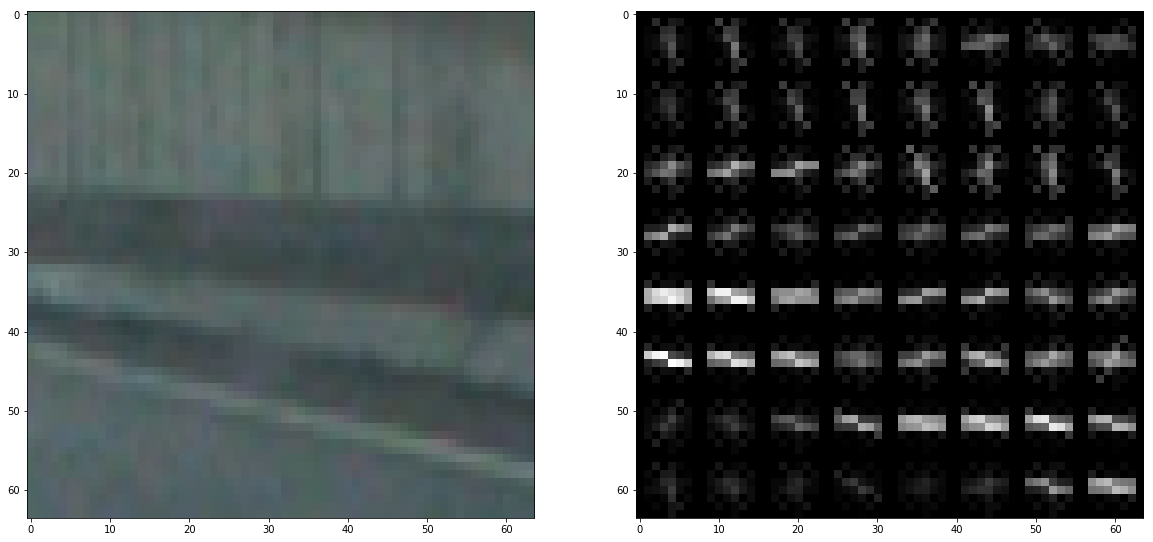

In [5]:
# Random non-car image
nonCarImage = mpimg.imread(non_vehicles_images[np.random.randint(0, len(non_vehicles_images))])
print("Image Size: ", nonCarImage.shape )
features, hog_image = get_hog_features(cv2.cvtColor(nonCarImage, cv2.COLOR_RGB2GRAY), orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)

f, (a1, a2) = plt.subplots(1,2,figsize=(20,10))
a1.imshow(nonCarImage)
a2.imshow(hog_image, cmap='gray')

In [6]:
import matplotlib.image as mpimg
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        image = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [7]:
import time
from sklearn.model_selection import train_test_split

# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t1 = time.time()
car_features = extract_features(vehicles_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
non_car_features = extract_features(non_vehicles_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))


# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

216.33 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [8]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

14.42 Seconds to train SVC...
Test Accuracy of SVC =  0.9659
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.0 Seconds to predict 10 labels with SVC


In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1 
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features.reshape(1,-1))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [11]:
testImage = mpimg.imread('./test_images/test1.jpg')

image_height = testImage.shape[0]
ystart = (image_height//2)+30
ystop = image_height-20
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(testImage, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

7 rectangles found in image


In [12]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

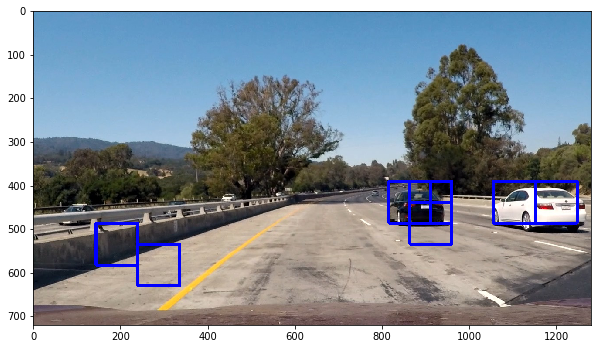

In [13]:
test_img_rects = draw_boxes(testImage, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

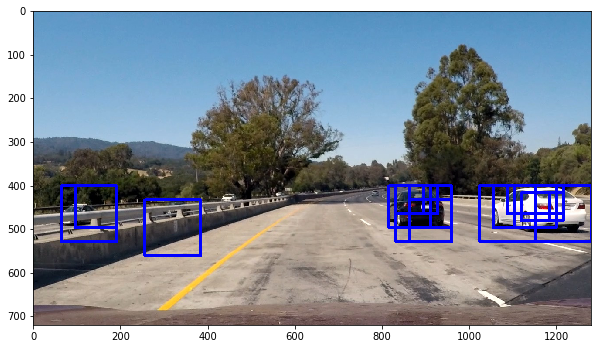

In [25]:
testImage = mpimg.imread('./test_images/test1.jpg')

def configuration_rectangles(rectangles, img, ystart, ystop, scale):
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
    
    return rectangles

rectangles = []
rectangles = configuration_rectangles(rectangles, testImage, 400, 464, 1.0)
rectangles = configuration_rectangles(rectangles, testImage, 416, 480, 1.0)
rectangles = configuration_rectangles(rectangles, testImage, 400, 496, 1.5)
rectangles = configuration_rectangles(rectangles, testImage, 432, 528, 1.5)
rectangles = configuration_rectangles(rectangles, testImage, 400, 528, 2.0)
rectangles = configuration_rectangles(rectangles, testImage, 432, 560, 2.0)
rectangles = configuration_rectangles(rectangles, testImage, 400, 596, 3.5)
rectangles = configuration_rectangles(rectangles, testImage, 464, 660, 3.5)

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
testImageRectangles = draw_boxes(testImage, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(testImageRectangles)

## Heatmap

In [26]:
def draw_heatmap(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

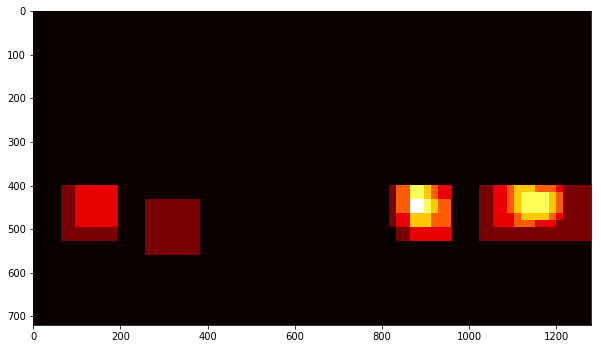

In [27]:
testImage = mpimg.imread('./test_images/test1.jpg')
heatmapImg = np.zeros_like(testImage[:,:,0])
heatmapImg = draw_heatmap(heatmapImg, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmapImg, cmap='hot')

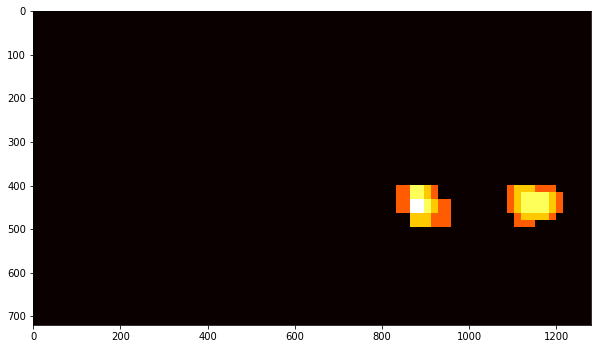

In [28]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap_img = apply_threshold(heatmapImg, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


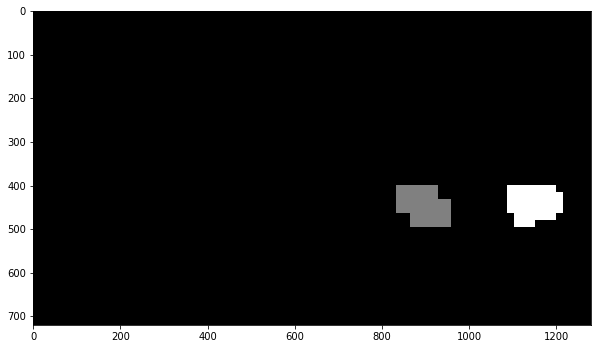

In [29]:
from scipy.ndimage.measurements import label
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

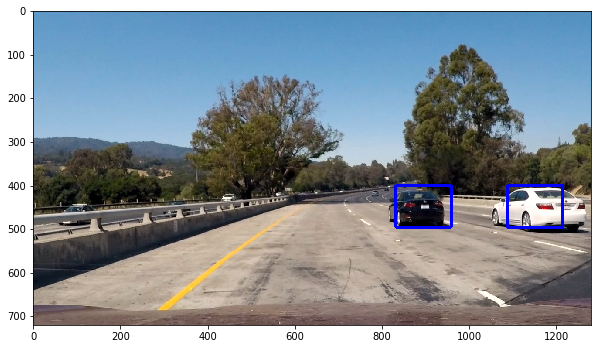

In [30]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(testImage), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [43]:
def process_frame(img):

    rectangles = []

    rectangles = configuration_rectangles(rectangles, img, 400, 464, 1.0)
    rectangles = configuration_rectangles(rectangles, img, 416, 480, 1.0)
    rectangles = configuration_rectangles(rectangles, img, 400, 496, 1.5)
    rectangles = configuration_rectangles(rectangles, img, 432, 528, 1.5)
    rectangles = configuration_rectangles(rectangles, img, 400, 528, 2.0)
    rectangles = configuration_rectangles(rectangles, img, 432, 560, 2.0)
    rectangles = configuration_rectangles(rectangles, img, 400, 596, 3.5)
    rectangles = configuration_rectangles(rectangles, img, 464, 660, 3.5)

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = draw_heatmap(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 2)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

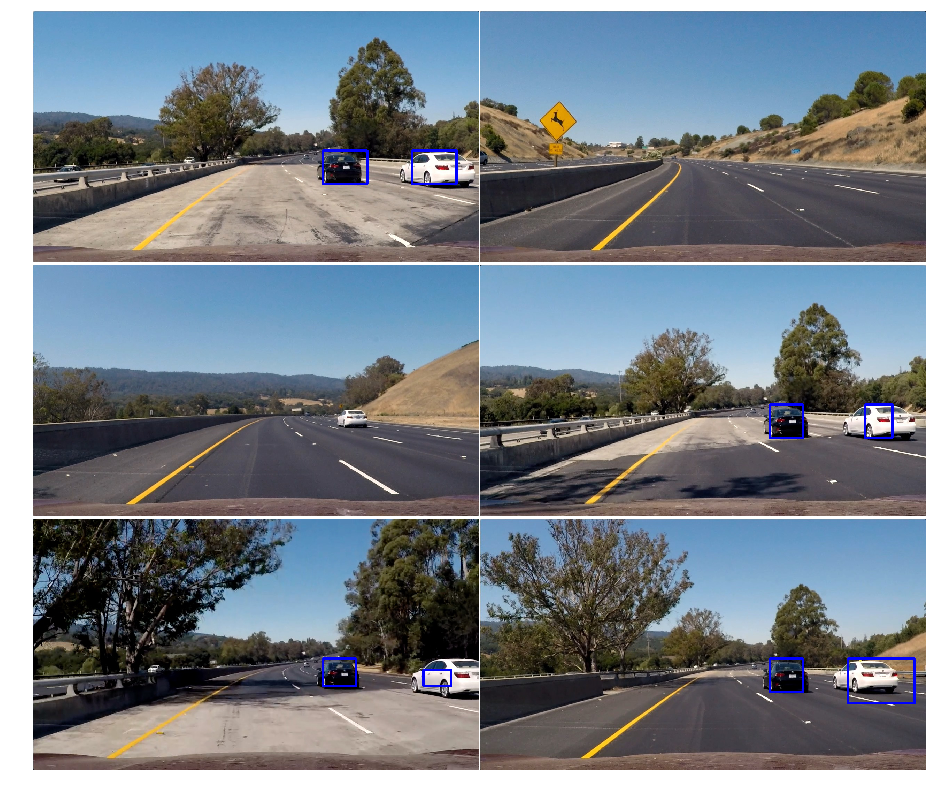

In [44]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [45]:
from moviepy.editor import VideoFileClip
test_out_file = 'project_video_output.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:43<00:00,  3.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 6min 44s


In [46]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

# **Vehicle Detection Project** 

---

**Vehicle Detection Project**

A Self-driving car needs to detect other vehicles on the road to safely drive. The goal of this project is to detect other vehicles on the road using images from the roof top-mounted camera on self driving car.

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/car_hog.png
[image3]: ./examples/non_car_hog.png
[image4]: ./examples/sliding_window_test_1.png
[image5]: ./examples/pipelineTEstImages.png
[image6]: ./examples/heatmap1.png
[image7]: ./examples/label1.png
[image8]: ./examples/final_output.png

---

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first five code cell of the IPython notebook.  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is example using the `RGB` color space and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)` for a car and a non-car image:


![alt text][image2]

![alt text][image3]

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of color space and HOG parameters like orientation, pixels per cell, HOG channels and the cells per block.

I mixed and randomized the vehicles and non-vehicles data set. Then, I bifurcated the randomized mixed data set with 80% training and 20% testing data. I extracted the HOG features to train the SVC and later evaluate the accuracy performance over the test set. I have used the accuracy as the measure of selecting the HOG parameters. With  
```
colorspace = 'YUV' 
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'
```
parameters, I achieved test set accuracy of 96.5%, which is best as compared to my other experiments on combination of HOG parameters value.
PS: I got the idea of these value from the work at https://github.com/jeremy-shannon/CarND-Vehicle-Detection

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using just HOG features. The code for training over the training data set lies in 8th cell of the IPython notebook.
I mixed and randomized the vehicles and non-vehicles data set. Then, I bifurcated the randomized mixed data set with 80% training and 20% testing data. I extracted the HOG features to train the SVC and later evaluate the accuracy performance over the test set

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I searched for a car in the desired region of the image (sampled space from the image and rescalling to 64x64px) with a desired window size (64x64 px) before classifying with my ```svc``` classifier. 

I used the middle half of the images as search space to search for the cars. I have picked the empirical cordinates pixel values to try various scaling window sizes for the car search.
Here is an example of the sliding window overlapped over first test image.

![alt text][image4]

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on 4 scales (1.0, 1.5, 2.0, 3.5) using YUV 3-channel HOG features in the feature vector, which provided a decent result (not very good).  Here are some example images:

![alt text][image5]
---

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video_output.mp4)


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an image showing the heatmap from a test image 1, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:


![alt text][image6]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image7]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image8]



---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

I could'nt spare much time to this project. But I genuinely feel there is lot of room for improvement as the video output contains a lot of false car detections. the pipeline is likely to fail is varying color combinations of the video. To make it more robust, I think of following pointers:
1. Adding Color and Gradient features in addition to HOG for training the classifier.
2. Experimenting more with the HOG / Color / Gradient parameters.
3. Augmenting training examples of car and non-car images. Better training, better accuracy.
4. Smoothening out the false detection in the video frames.

